In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

def get_ts_centers_no_mod(model: TwoOsillators):
    sa = StateAnalysis(model, classDistance=0.3, lookIndex=0)
    ts_centers = []
    for i in range(1, sa.totalPhaseTheta.shape[0]):
        positionx = sa.totalPositionX[i, :, 0]
        positiony = sa.totalPositionX[i, :, 1]
        pointTheta = sa.totalPointTheta[i, :]
        center = np.array([
            positionx - model.speedV * model.dt / pointTheta * np.sin(sa.totalPhaseTheta[i, :]),
            positiony + model.speedV * model.dt / pointTheta * np.cos(sa.totalPhaseTheta[i, :])
        ]).T
        ts_centers.append(center)
    ts_centers.insert(0, ts_centers[0])
    return np.array(ts_centers)

In [2]:
model = TwoOsillators(
    strengthLambda=2, r0=1, typeA="heaviside", omega1=3, omega2=2, dt=0.01, couplesNum=1, 
    savePath="./data", overWrite=True, tqdm=True
)
model.run(20000)

  0%|          | 0/20000 [00:00<?, ?it/s]

(-5.0, 5.0)

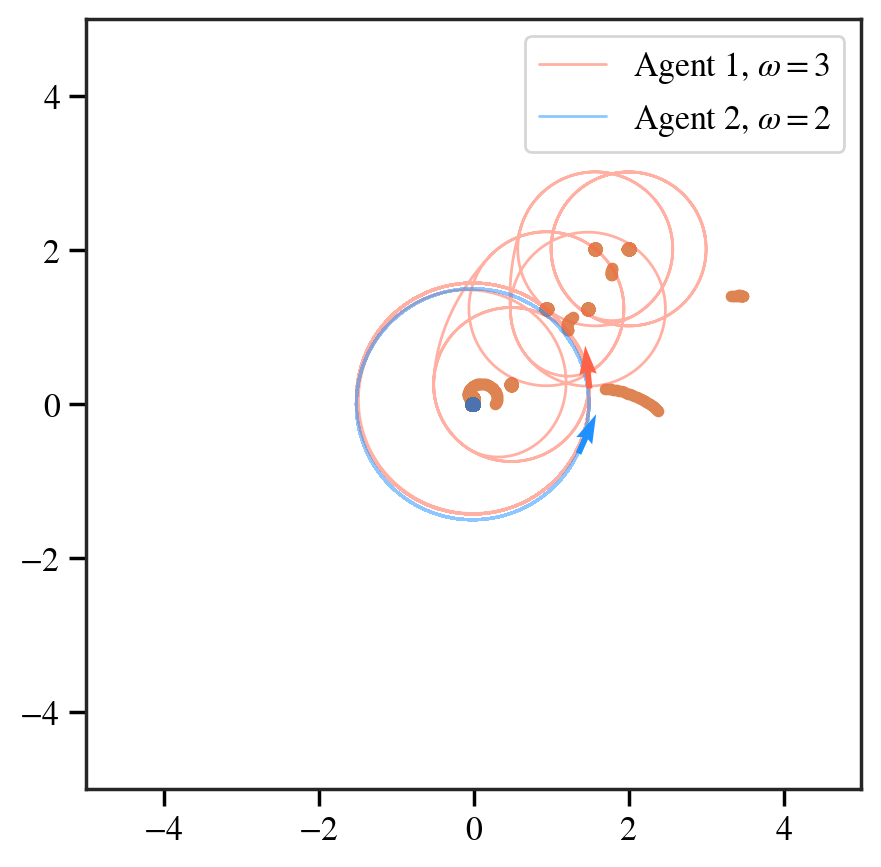

In [3]:
# model = models[1]
targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2).transpose(0, 1, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta[0] = np.nan
fig, ax = plt.subplots(figsize=(5, 5))
trajectoryLength = 0
plt.plot(totalPositionX[-trajectoryLength:, 0, 0], totalPositionX[-trajectoryLength:, 0, 1], color="tomato", alpha=0.5, lw=1)
plt.plot(totalPositionX[-trajectoryLength:, 1, 0], totalPositionX[-trajectoryLength:, 1, 1], color='dodgerblue', alpha=0.5, lw=1)
plt.quiver(
    totalPositionX[-1, 0, 0], totalPositionX[-1, 0, 1],
    np.cos(totalPhaseTheta[-1, 0]), np.sin(totalPhaseTheta[-1, 0]), color="tomato", zorder=10
)
plt.quiver(
    totalPositionX[-1, 1, 0], totalPositionX[-1, 1, 1],
    np.cos(totalPhaseTheta[-1, 1]), np.sin(totalPhaseTheta[-1, 1]), color="dodgerblue", zorder=10
)
plt.scatter(
    totalPositionX[:, 1, 0] - 3 * model.dt / totalPointTheta[:, 1] * np.sin(totalPhaseTheta[:, 1]),
    totalPositionX[:, 1, 1] + 3 * model.dt / totalPointTheta[:, 1] * np.cos(totalPhaseTheta[:, 1]), s=10, zorder=10
)
plt.scatter(
    totalPositionX[:, 0, 0] - 3 * model.dt / totalPointTheta[:, 0] * np.sin(totalPhaseTheta[:, 0]),
    totalPositionX[:, 0, 1] + 3 * model.dt / totalPointTheta[:, 0] * np.cos(totalPhaseTheta[:, 0]), s=10
)
plt.legend([fr"Agent 1, $\omega={model.omegaTheta[0]}$", fr"Agent 2, $\omega={model.omegaTheta[1]}$"])

bound = 5
plt.xlim(-bound, bound)
plt.ylim(-bound, bound)

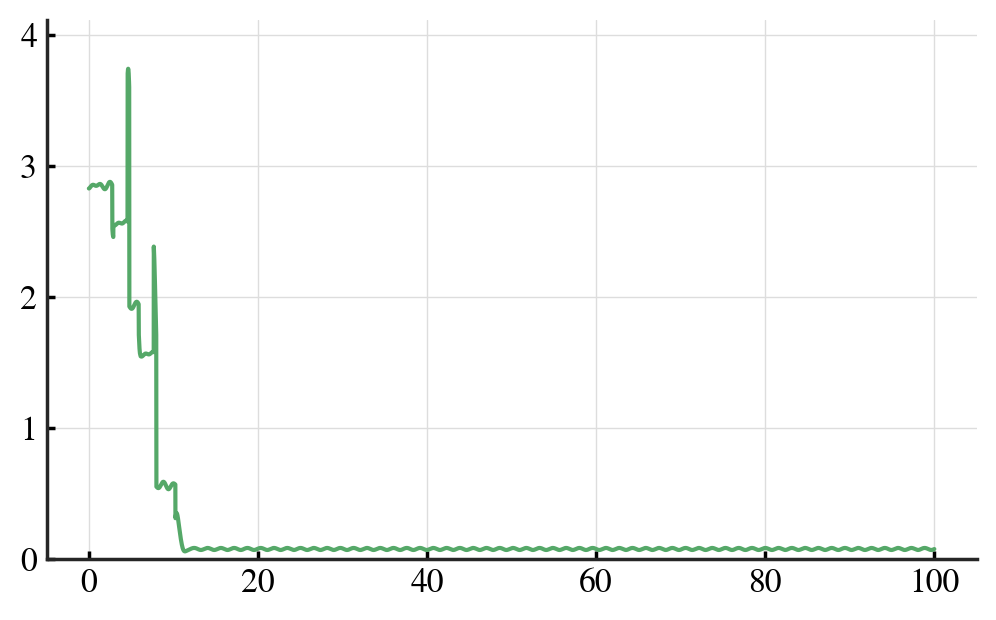

In [4]:
plt.subplots(1, 1, figsize=(6, 3.5))
colorIdx = 2

targetPath = f"./data/{model}.h5"
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
tsCentersNoMod = get_ts_centers_no_mod(model)
sub = tsCentersNoMod[:, 0] - tsCentersNoMod[:, 1]
distance = np.sqrt(np.sum(sub ** 2, axis=1))
omega1, omega2 = model.omegaTheta
x = np.arange(len(distance)) * model.dt
plt.plot(x, distance, color=f"C{colorIdx}",
            label=fr"$d_0={model.r0}, \omega_1={omega1}, \omega_2={omega2}$")
# plt.axline((0, model.distanceD0 + np.sum(3 / np.abs(model.omegaTheta))), slope=0, 
#             color=f"C{colorIdx}", linestyle="--", alpha=0.8, lw=1)
colorIdx += 1
plt.ylim(0, distance.max() * 1.1)

plt.tick_params(direction='in', length=3)
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [5]:
from sympy import symbols

theta1, theta2